# Fitting a Gaussian Distribution

*Erik Tollerud*

[Back to Session 1](Session%201.ipynb)

Here we're going to explore some of the core ideas of Bayesian parameter estimation using the most normal of probability distributions: the Gaussian.

Before starting, I want to emphasize: a lot of these results can just as easily be obtained via derivation of analytic forms of various probability distributions. If this is the sort of thing that makes more sense to you, you may find you want to stop here and immediately go back to some of the [resources](Session%201.ipynb#Additional-Resources) I linked to earlier - the more traditional "textbook" formalism in particular will teach you some elegant and efficient mathematical approaches that work well for well-behaved functions like the Gaussian.

But I find I often need to build intuition using numerical experiments, and it is that which this notebook aims to do.

## Basic imports

Some standard Python imports we know we'll need

In [1]:
import numpy as np
from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

## A basic dataset drawn from a Gaussian

Lets start by creating a Gaussian dataset with a known center and $\sigma$.  Note that I am not setting a random number seed - this means your results will look a bit different from everyone else's. Woohoo, letting loose is fun isn't it?!

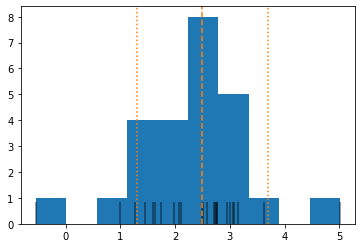

In [2]:
N = 25
center = 2.5
sigma = 1.2

data = np.random.randn(N) * sigma + center

plt.hist(data)

plt.axvline(center, c='C1', ls='--')
plt.axvline(center-sigma, c='C1', ls=':')
plt.axvline(center+sigma, c='C1', ls=':')

plt.vlines(data, 0, plt.ylim()[-1]*.1, color='k', alpha=.5);

So if we *don't* know the answer, how would we infer the center and width of this distribution?  The traditional frequentist way, we simply apply maximum likelihood estimation. If you work through the math (you can do it yourself or cheat by looking e.g. [here](http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html)), you find that's something we all learned at our grandparents' knees:

In [3]:
np.mean(data)

2.380373580786389

In [4]:
np.std(data)

1.020144278276627

To be fair, that's what makes it a "standard" deviation.  But still, good to see that it works out. To see it in action, we can visualize the likelihood surface for this distribution near these answers.  To understand how we're doing this, it's important to remember that the likelihood here depends on the *data* - for any given data point it's the Gaussian probability density function (conveniently availible as `scipt.stats.norm.pdf` with the "data" value held fixed and the center and $\sigma$ as free variables.  However since we have *multiple* data points, which we assume to be independent, we can apply the probability rule:

$P(D_1 \cap D_2) = P(D_1)P(D_2)$, so $P({\rm all}\; D_i) = \prod_{i=1}^n P(D_i)$

however, these products can quickly get very large/small, to the point that the rounding errors in the computer can dominate.  So it's usually safer to take the log of these probabilities and *sum* them instead of doing the product.  For that reason log-likelihoods are ubiquitous almost everywhere in computation probabilistic work:

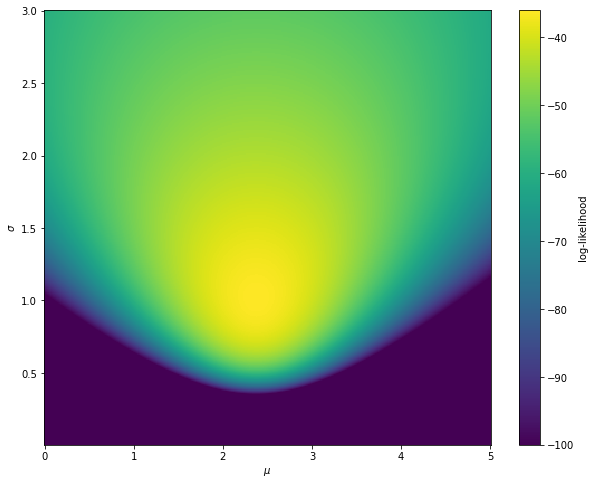

In [58]:
cens, sigs = np.meshgrid(np.linspace(0, 5, 400), np.linspace(0, 3, 351)[1:])
dcen = cens[0, 1] - cens[0, 0]
dsig = sigs[1,0] - sigs[0,0]


loglikelihoods = stats.norm.logpdf(data[:,np.newaxis,np.newaxis], loc=cens, scale=sigs)
sumllike = np.sum(loglikelihoods, axis=0)
                
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pc = ax.pcolor(cens, sigs, sumllike, shading='auto', vmin=-100)  # you may need to fiddle with vmin to make this look reasonable
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
fig.colorbar(pc).set_label('log-likelihood')

Hmm, it's not that obvious where the maximum is. So lets try computing it numerically, and while we're at it, compare to the analytic result (and the "true" answer):

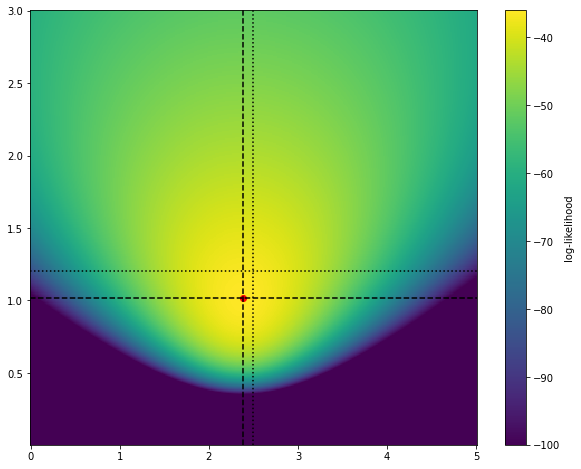

In [6]:
# find the grid point where it's maximized and plot that as a scatter point
maxi = np.argmax(sumllike)
ax.scatter([cens.ravel()[maxi]], [sigs.ravel()[maxi]], c='r')

ax.axvline(np.mean(data),c='k', ls='--')
ax.axhline(np.std(data),c='k', ls='--')

# "true" answers
ax.axvline(center,c='k', ls=':')
ax.axhline(sigma,c='k', ls=':')


fig

(Note: if you find the ML and "true" answer are very close together you might want to re-generate your dataset.  It'll make the rest more interesting, I promise)

Now's a great time to make an observation: you may be wondering about the scare-quotes in "true".  The core point here is that it's only in the frequentist interpretation that "true" has any meaning. While the way we phrased this experiment it seems like a valid idea, in a real inferential situation where you only have access to reality through the data as given, the best estimate is the *only* answer that's worth talking about, so the maximum likelihood estimates are as "true" as the numbers used to initialize this example.

## Priors and the MAP

The above example centered on the maximum-likelihood estimate.  However, this is an inherently frequentist construct.  In Bayesian inference, the closest comparable concept is the "Maximum a posteriori" estimator (MAP). This is similar to maximum likelihood in execution, but conceptually critically different: it includes in explicit prior. In practice it is straightforwardly derived from Bayes' Theorem for paramemeter inference by dropping terms that don't depend on $\Theta$:


${\rm MAP} \equiv {\rm argmax}_\Theta P(\Theta| D) = {\rm argmax}_\Theta  [P(D| \Theta) P(\Theta)]$

which is distinguished from the maximum likelihood only by the factor for the prior probability. 

From this we can see that the maximum likelihood estimator equivalent to the MAP under the assumption of a uniform prior distribution in all parameters.  While in practice a uniform prior over all reals is an "improper prior" (not normalizable), in some cases this isn't in issue if the problem is still analytically tractible. But for the numerical experiment we see immediately there is a need to constrain the domain - the experiment above applied uniform priors $\mu = U[0, 5]$, $\sigma = U(0, 3]$, but for the MAP this has little consequence as long as the maximum is within the window in question.

This situation changes if we revisit the concept of "true", however.  Suppose we have an external reason to believe that our "true" answer is the right answer. The MAP allows us to influence the result by inserting that belief into the experiment:

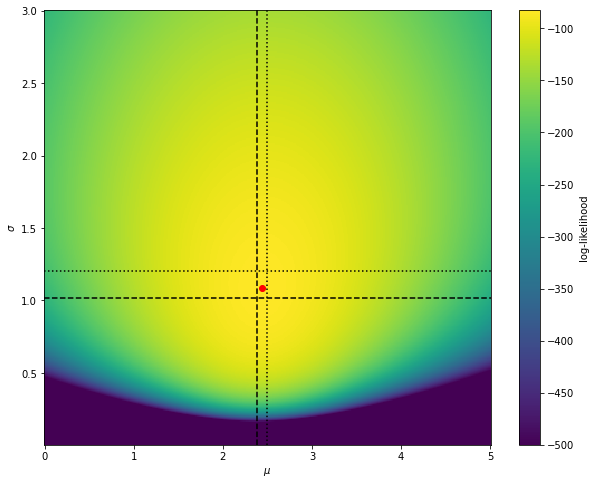

In [9]:
cen_logprior = stats.norm.logpdf(cens, loc=center, scale=1)
sig_logprior = stats.norm.logpdf(sigs, loc=sigma, scale=1)

sumlposterior = np.sum(loglikelihoods+cen_logprior+sig_logprior, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
pc = ax.pcolor(cens, sigs, sumlposterior, shading='auto', vmin=-500)  # you may need to fiddle with vmin to make this look reasonable


maxi = np.argmax(sumlposterior)
ax.scatter([cens.ravel()[maxi]], [sigs.ravel()[maxi]], c='r')

# ML estimates
ax.axvline(np.mean(data),c='k', ls='--')
ax.axhline(np.std(data),c='k', ls='--')

# "true" answers
ax.axvline(center,c='k', ls=':')
ax.axhline(sigma,c='k', ls=':')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
fig.colorbar(pc).set_label('log-likelihood')

We see here that the MAP is now between the two possible answers, because we applied prior knowledge to 

### Experiments to try:

1. Fiddle around with the `scale` parameter on the `cen_logprior` and `sig_logprior` lines in the above cell.  Do you get the expected limiting behavior?
2. What happens when you change the number of datapoints? What impact does it have on the MAP and how it differs from the ML estimate?

## Beyond the MAP

At this point it's worth discussing a subtle but important distinction hiding in the plots above: the use of "point estimates" versus probability distributions.  While a frequentist approach is often happy to stop at the Maximum Likelihood estimate, the Bayesian is not. Bayesian inference typically seeks the Posterior Probability Distribution, which is an entire probability distribution characterizing how likely any given parameter combination is instead of a "best estimate".  

Fortunately, this has in fact been hiding in plain sight above - the 2d plots shown *are* the (unnormalized) log of the posterior.  With that in mind, we can take things one step further and use a more typical Bayesian approach of using *marginal* probability distributions (i.e., summed along the other parameters):

In [79]:
# helper function for below
def get_quantiles(xs, ys, quantiles=[.1, .5, .9]):
    cdf = np.cumsum(ys/np.sum(ys))
    qs = np.interp(quantiles, cdf, xs)
    return qs[1], qs[2]-qs[1], qs[1]-qs[0]

Uniform: 2.37 +0.28 -0.28
Strong Prior: 2.44 +0.19 -0.19


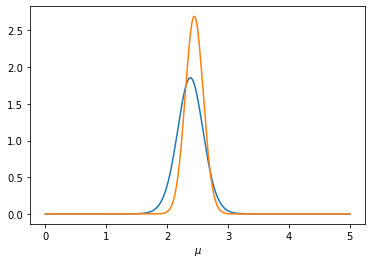

In [86]:
mu_margin_ml = np.sum(np.exp(sumllike), axis=0)
plt.plot(cens[0], mu_margin_ml/np.sum(mu_margin_ml*dcen))

mu_margin_post = np.sum(np.exp(sumlposterior), axis=0)
plt.plot(cens[0], mu_margin_post/np.sum(mu_margin_post*dcen))

plt.xlabel('$\mu$')

print('Uniform: {0:.3} +{1:.2} -{2:.2}'.format(*get_quantiles(cens[0], mu_margin_ml)))
print('Strong Prior: {0:.3} +{1:.2} -{2:.2}'.format(*get_quantiles(cens[0], mu_margin_post)))

Uniform: 1.07 +0.24 -0.18
Strong Prior: 1.11 +0.18 -0.16


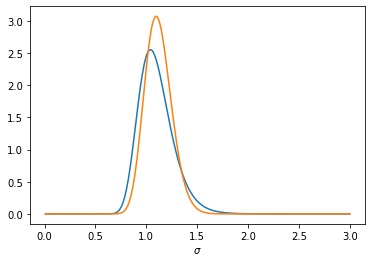

In [87]:
mu_margin_ml = np.sum(np.exp(sumllike), axis=1)
plt.plot(sigs[:, 0], mu_margin_ml/np.sum(mu_margin_ml*dsig))

mu_margin_post = np.sum(np.exp(sumlposterior), axis=1)
plt.plot(sigs[:, 0], mu_margin_post/np.sum(mu_margin_post*dsig))

plt.xlabel('$\sigma$')

print('Uniform: {0:.3} +{1:.2} -{2:.2}'.format(*get_quantiles(sigs[:, 0], mu_margin_ml)))
print('Strong Prior: {0:.3} +{1:.2} -{2:.2}'.format(*get_quantiles(sigs[:, 0], mu_margin_post)))

Try making these again following the same experiments as before:

1. Fiddle around with the `scale` parameter on the `cen_logprior` and `sig_logprior` lines in the above cell.  Do you get the expected limiting behavior?
2. What happens when you change the number of datapoints? What impact does it have on the MAP and how it differs from the ML estimate?

## Are there any "uninformative" priors?

Armed with the tools to investigate this deceptively simple distribution, one last are is worth exploring: if we don't have any obvious "truth" to work from, what are a good set of priors? This is in fact a very active area of stats research. (There is in fact a [whole chapter of the International Society for Bayesian Analysis on this topic](https://bayesian.org/sectionschapters/objective-bayes/).)  So you can take that as either "there are lots of resources" or "it's really complicated, so just try something and hope for the best."  

For the Gaussian there's some interesting results to consider though - there as a useful concept called the ["Jeffrey's prior"](https://royalsocietypublishing.org/doi/10.1098/rspa.1946.0056) which generalizes to many other cases (if the original article is too hard going, there's a reasonable derivation [on wikipedia](https://en.wikipedia.org/wiki/Jeffreys_prior) based on it).  The basic gist is: for a "location" parameter (like $\mu$ of a Gaussian), a uniform prior is the least informative, but for a "scale" parameter (like $\sigma$ of a Gaussian), the least informative prior is $\frac{1}{\sigma}$.  While the Jeffrey's prior derivation quickly becomes complex for all but the most straightforward of distributions, these rules-of-thumb based on the Gaussian priors may still have some value.

So as a final experiment (and exercise for the reader), replicate the above but using the Jeffrey's priors for the Gaussian.  What do you see, particularly in the case of low-N?